In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/uber-request-data/Uber Request Data.csv


## Uber Supply Demand Gap

#### Business Objective

##### Supply Demand Gap of Uber Bookings from Two pickup points : Airport and City

#### Exploratory Data Analysis
To visualyse the gap in various time slots and analysing the reasons of failed trip requests.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from numpy import median
import seaborn as sns
sns.set_style("whitegrid")
import calendar
import datetime

uber=pd.read_csv("/kaggle/input/uber-request-data/Uber Request Data.csv")
print(uber.info())
uber.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB
None


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


****Trip Status of all requests

In [3]:

statuscount=uber[["Request id","Status"]].groupby("Status").count()
statuscount

,Request id
Status,
Cancelled,1264
No Cars Available,2650
Trip Completed,2831


In [4]:



#Missing Data Check
uber.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

****"Driver id" column has 2650 missing as shown above but this is equal to the "No cars Available" trip status, hence there are no missing values
"Drop Timestamp" columns has 3914 missing values which is the sum of "No cars Available" ,2650 + 1264 for "Cancelled" 
We can see that there is no missing data as such n the dataset.
uber[["Request id","Status"]].groupby("Status").count().plot(kind="pie",subplots="True",autopct='%1.0f%%',
        shadow=True, startangle=90, figsize=[5,5],colormap="Pastel1")


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7d2e2487c9b0>],
      dtype=object)

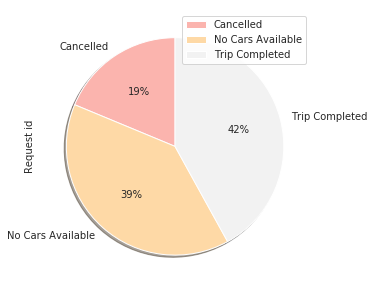

In [5]:
uber[["Request id", "Status"]].groupby("Status").count().plot(
    kind="pie",
    subplots=True,  # Use True to create subplots for each column
    autopct='%1.0f%%',
    shadow=True,
    startangle=90,
    figsize=(5, 5),
    colormap="Pastel1"
)

****There is a very big supply demand gap
Only 42 percent of the total trip requests are being completed
There are a total of 19 percent trips that are being cancelled by the driver
There are 39 percent trip requests which are being turned down due to unavailabiltity of cars
Hence a bigger problem is car unavailability and need to be tackled depending on the where the request is coming from , Airport or city.
Trip Status: Airpot to City and City to Aiport


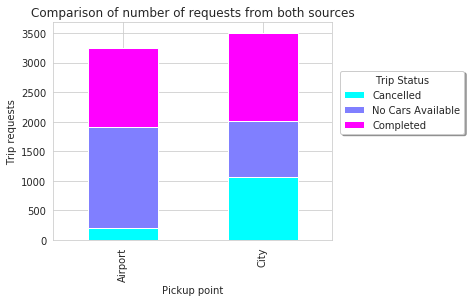

In [6]:
reqtype=uber[["Request id","Status","Pickup point"]].groupby(["Pickup point","Status"]).count()

reqtype.unstack().plot(kind='bar', stacked=True, figsize=[5,4],colormap="cool")
plt.xlabel("Pickup point")
plt.ylabel("Trip requests")
plt.title("Comparison of number of requests from both sources")
plt.legend(title='Trip Status',loc='upper center', bbox_to_anchor=(1.25, 0.8), shadow=True, ncol=1, labels=['Cancelled', 'No Cars Available', 'Completed'])


****Visualising percentage of trips for each status from Airport to city and city to airport


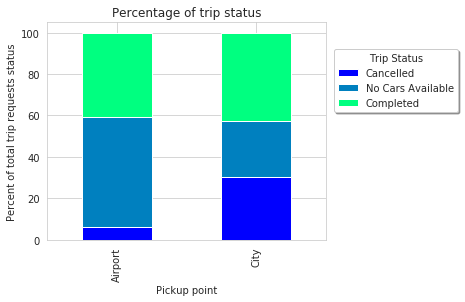

In [7]:

percentgap=reqtype.unstack()
percentgap["Cancel%"]=percentgap["Request id"]["Cancelled"]/percentgap.iloc[0:,:3].sum(axis=1)*100
percentgap["NoCarsAvailable%"]=percentgap["Request id"]["No Cars Available"]/percentgap.iloc[0:,:3].sum(axis=1)*100
percentgap["TripCompleted%"]=percentgap["Request id"]["Trip Completed"]/percentgap.iloc[0:,:3].sum(axis=1)*100

percentgap.iloc[0:,3:].plot(kind='bar', stacked=True, figsize=[5,4],colormap="winter")
plt.xlabel("Pickup point")
plt.ylabel("Percent of total trip requests status")
plt.title("Percentage of trip status")
plt.legend(title='Trip Status', loc='upper center', bbox_to_anchor=(1.25, 0.9), shadow=True, ncol=1, labels=['Cancelled', 'No Cars Available', 'Completed'])


****More problematic Pickup point is Airport with 59% (53%- non availability of cars and 6%- cancellations) supply demand gap
City has 57 % (27%- non availability of cars and 30%- cancellations)supply demand gap



****Creating Derived Metrics from request timestamp:
Hour of trip request,
Day of the week
Time slots : early morning, monring, afternoon, evening, night and late night.


In [8]:
uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'])
uber['reqhour']=uber['Request timestamp'].dt.hour
uber['Day'] = uber['Request timestamp'].apply(lambda x: datetime.datetime.strftime(x, '%A'))
uber.head()



,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,reqhour,Day
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,11/7/2016 13:00,11,Monday
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,11/7/2016 18:47,17,Monday
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,12/7/2016 9:58,9,Wednesday
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,12/7/2016 22:03,21,Wednesday
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,13-07-2016 09:25:47,8,Wednesday


****Days of the week

<Figure size 1080x720 with 0 Axes>

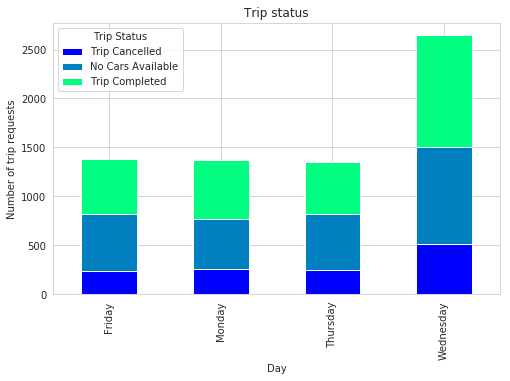

In [9]:


tripday=uber[["Request id","Status","Day"]].groupby(["Day","Status"]).count().unstack()
plt.figure(figsize=(15,10))
tripday.plot(kind='bar', stacked=True, figsize=[8,5], legend=True,colormap="winter")
plt.xlabel("Day")
plt.ylabel("Number of trip requests")
plt.title("Trip status")
plt.legend(title='Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()


****Days of the week: Comparing both Pickup Points


<Figure size 1080x720 with 0 Axes>

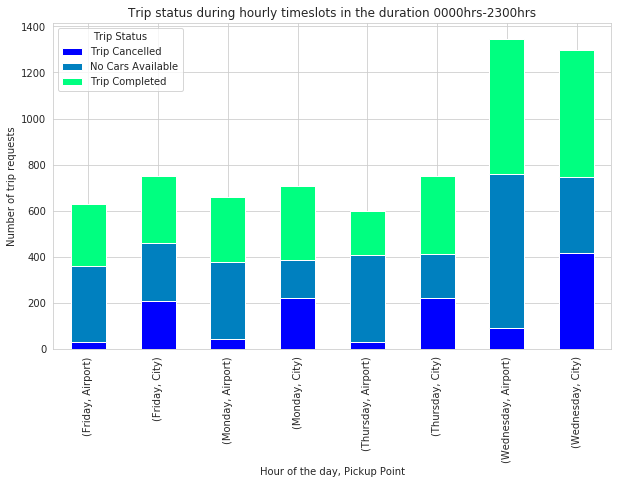

In [10]:

timeslots=uber[["Request id","Status","Day","Pickup point"]].groupby(["Day","Pickup point","Status"]).count()
plt.figure(figsize=(15,10))
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[10,6], legend=True,colormap="winter")
plt.xlabel("Hour of the day, Pickup Point")
plt.ylabel("Number of trip requests")
plt.title("Trip status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title='Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()


****Hours of the day: All trips both pickup points combined

<Figure size 1080x720 with 0 Axes>

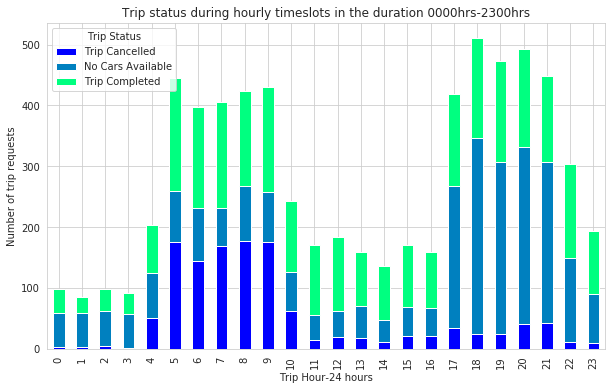

In [11]:


timeslots=uber[["Request id","Status","reqhour"]].groupby(["reqhour","Status"]).count()
plt.figure(figsize=(15,10))
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[10,6], legend=True,colormap="winter")
plt.xlabel("Trip Hour-24 hours")
plt.ylabel("Number of trip requests")
plt.title("Trip status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title='Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()





****Hours of the day: Aiport and City Comparison Chart


<Figure size 1080x720 with 0 Axes>

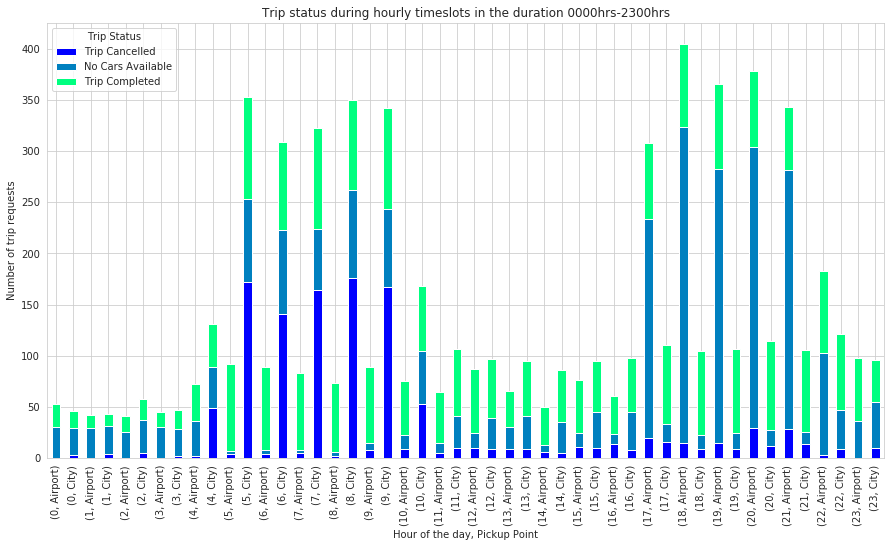

<Figure size 1080x720 with 0 Axes>

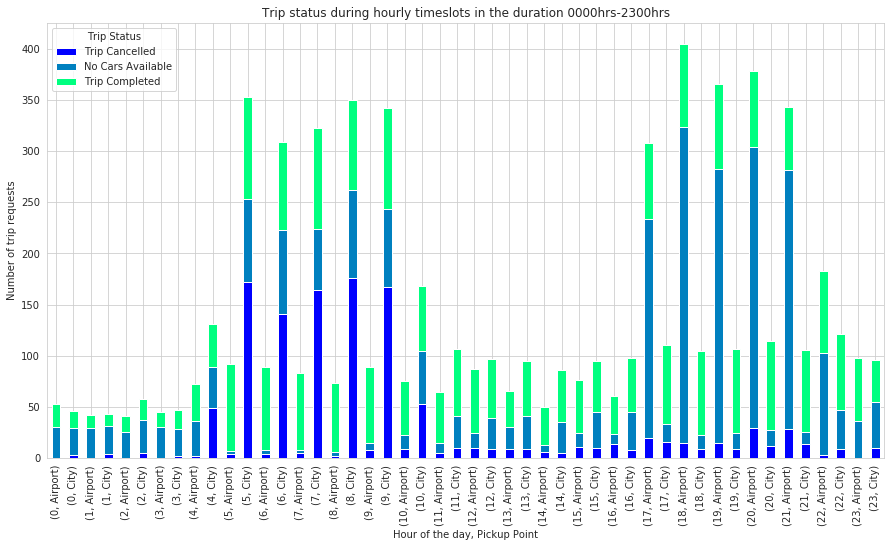

In [12]:
timeslots=uber[["Request id","Status","reqhour","Pickup point"]].groupby(["reqhour","Pickup point","Status"]).count()
plt.figure(figsize=(15,10))
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[15,8], legend=True,colormap="winter")
plt.xlabel("Hour of the day, Pickup Point")
plt.ylabel("Number of trip requests")
plt.title("Trip status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title='Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()
timeslots=uber[["Request id","Status","reqhour","Pickup point"]].groupby(["reqhour","Pickup point","Status"]).count()
plt.figure(figsize=(15,10))
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[15,8], legend=True,colormap="winter")
plt.xlabel("Hour of the day, Pickup Point")
plt.ylabel("Number of trip requests")
plt.title("Trip status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title='Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()


****Most problematic timeslots with highest gap: 0500-0900hrs and 1700-2100hrs with more than 400 requests and approx. 150 getting completed . A supply demand gap of 70-80% exists in these timeslots


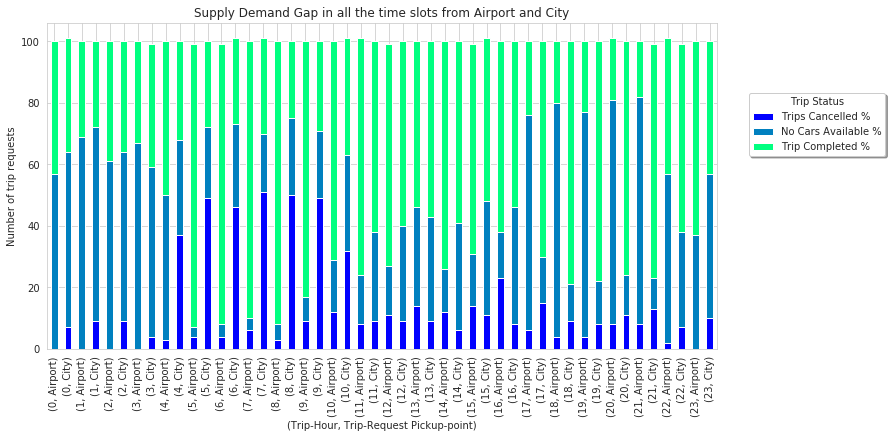

In [13]:
# create dataframe of trip status value counts for city and airport 
sd=uber[["Request id","Status","reqhour","Pickup point"]].groupby(["reqhour","Pickup point","Status"]).count().unstack()

# fill nan values with 0 because Nan is for 0 count in respective trip status

supdem=sd.fillna(0)


cancel=round(supdem["Request id"]["Cancelled"]/supdem.sum(axis=1)*100)

nocars=round(supdem["Request id"]["No Cars Available"]/supdem.sum(axis=1)*100)

tripcomp=round(supdem["Request id"]["Trip Completed"]/supdem.sum(axis=1)*100)

dfs = [supdem, cancel, nocars, tripcomp]
supdemgap=pd.concat(dfs,axis=1)

supdemgap.columns=['Cancelled','No Cars Available','Trip Completed',"%cancelled", "%NoCarsAvail", "%TripCompleted"]

supdemgap.iloc[0:,3:].plot(kind='bar', stacked=True, figsize=[12,6],colormap="winter")
plt.xlabel("(Trip-Hour, Trip-Request Pickup-point)")
plt.ylabel("Number of trip requests")
plt.title("Supply Demand Gap in all the time slots from Airport and City")
plt.legend(title='Trip Status', loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1, labels=['Trips Cancelled %', 'No Cars Available %', 'Trip Completed %'])

****City to Airport : hours of the day


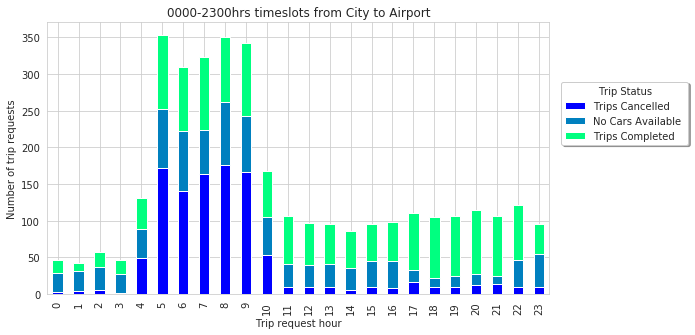

In [14]:
n=uber[["Request id","Status","reqhour","Pickup point"]].groupby(["reqhour","Pickup point","Status"]).count()
citysupdemgap=n.unstack().loc[sd.index.get_level_values("Pickup point")=="City"].reset_index(level="Pickup point", drop=True)
airportsupdemgap=n.unstack().loc[sd.index.get_level_values("Pickup point")=="Airport"].reset_index(level="Pickup point", drop=True)
citysupdemgap.plot(kind='bar', stacked=True, figsize=[9,5],colormap="winter")
plt.xlabel("Trip request hour")
plt.ylabel("Number of trip requests")
plt.title("0000-2300hrs timeslots from City to Airport")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available ', 'Trips Completed'],loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


****Trip Status Percentage - City to Airport - hours of the day


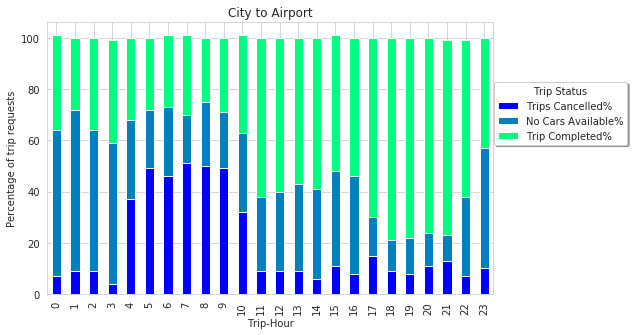

In [15]:
timepickcity=supdemgap.loc[supdemgap.index.get_level_values("Pickup point")=="City"].iloc[0:,3:].reset_index(level="Pickup point", drop=True)
timepickcity.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Trip-Hour")
plt.ylabel("Percentage of trip requests")
plt.title("City to Airport")
plt.legend(title='Trip Status', labels=['Trips Cancelled%', 'No Cars Available%', 'Trip Completed%'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)

****Trip Status Count -Airport to City - hours of the day


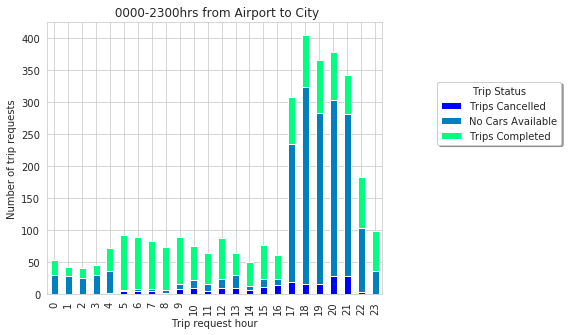

In [16]:
airportsupdemgap.plot(kind='bar', stacked=True, figsize=[6,5],colormap="winter")
plt.xlabel("Trip request hour")
plt.ylabel("Number of trip requests")
plt.title(" 0000-2300hrs from Airport to City")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trips Completed'],loc='upper center', bbox_to_anchor=(1.35, 0.8), shadow=True, ncol=1)


****Trip Status Percentage - Airport to City - Hours of the day


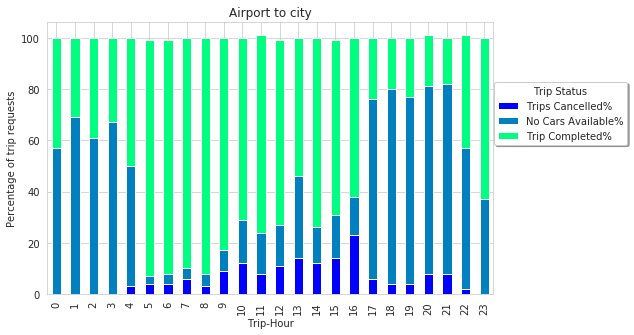

In [17]:

timepickair=supdemgap.loc[supdemgap.index.get_level_values("Pickup point")=="Airport"].iloc[0:,3:].reset_index(level="Pickup point", drop=True)
timepickair.plot(kind='bar',colormap="winter", stacked=True, figsize=[8,5],  title="Airport to city")

plt.xlabel("Trip-Hour")
plt.ylabel("Percentage of trip requests")

plt.legend(title='Trip Status', labels=['Trips Cancelled%', 'No Cars Available%', 'Trip Completed%'],loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


****Timeslots: Total Count from Both pickup points together
Trip Status Count - Early Morning to Late night Slots


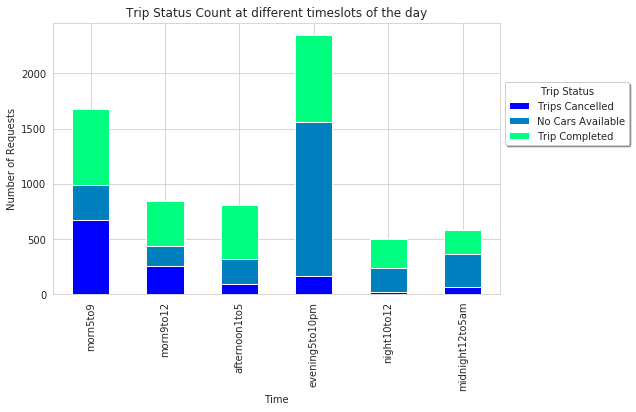

In [18]:
morn5to9=pd.DataFrame(sd.loc[5:8].sum())
morn9to12=pd.DataFrame(sd.loc[9:11].sum())
afternoon1to5=pd.DataFrame(sd.loc[12:16].sum())
evening5to10pm=pd.DataFrame(sd.loc[17:21].sum())
night10to12=pd.DataFrame(sd.loc[22:23].sum())
midnight12to5am=pd.DataFrame(sd.loc[0:4].sum())

slots=pd.concat([morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am],axis=1)

slots.columns=["morn5to9","morn9to12","afternoon1to5","evening5to10pm","night10to12","midnight12to5am"]

slots.reset_index(inplace=True)
slots.drop("level_0",axis=1,inplace=True)
slots.set_index("Status",inplace=True)
gap=slots.T
gap.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Trip Status Count at different timeslots of the day")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


In [19]:

total=slots.sum()
cancel=round((slots.loc["Cancelled"]/total)*100)
nocars=round((slots.loc["No Cars Available"]/total)*100)
tripcomp=round((slots.loc["Trip Completed"]/total)*100)
fail=slots.iloc[:2].sum()
failperc=round((fail/total)*100)
supply_dem_gap=pd.concat([gap,pd.DataFrame(columns =["%cancelled", "%NoCarsAvail", "%TripCompleted","%Failed_req",
           "failed requests","total_requests"])])
supply_dem_gap["%cancelled"]=cancel
supply_dem_gap["%NoCarsAvail"]=nocars
supply_dem_gap["%TripCompleted"]=tripcomp
supply_dem_gap["%Failed_req"]=failperc
supply_dem_gap["failed requests"]=fail
supply_dem_gap["total_requests"]=total
supply_dem_gap


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,%Failed_req,%NoCarsAvail,%TripCompleted,%cancelled,Cancelled,No Cars Available,Trip Completed,failed requests,total_requests
morn5to9,59.0,19.0,41.0,40.0,668.0,323.0,681.0,991.0,1672.0
morn9to12,52.0,22.0,48.0,30.0,252.0,189.0,404.0,441.0,845.0
afternoon1to5,39.0,28.0,61.0,11.0,91.0,228.0,491.0,319.0,810.0
evening5to10pm,67.0,59.0,33.0,7.0,166.0,1392.0,784.0,1558.0,2342.0
night10to12,48.0,44.0,52.0,4.0,22.0,219.0,257.0,241.0,498.0
midnight12to5am,63.0,52.0,37.0,11.0,65.0,299.0,214.0,364.0,578.0


****Trip Status Percentage - Early Morning to Late night Slots


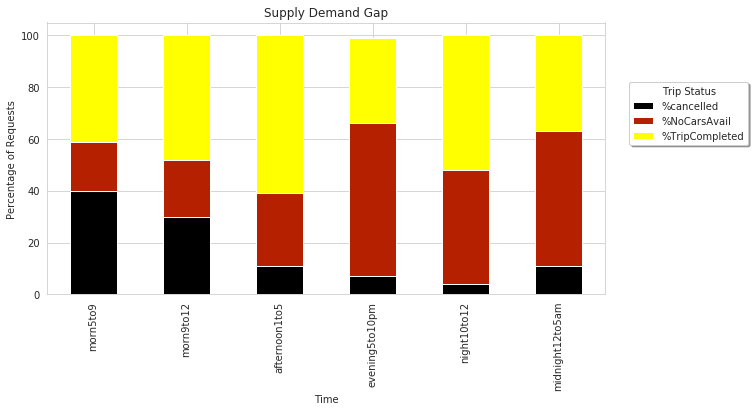

In [20]:
supply_dem_gap[["%cancelled", "%NoCarsAvail", "%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Percentage of Requests")
plt.title("Supply Demand Gap")
plt.legend(title='Trip Status', labels=["%cancelled", "%NoCarsAvail", "%TripCompleted"],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



****Failed and Successful Trip Percentage - Early Morning to Late night Slots


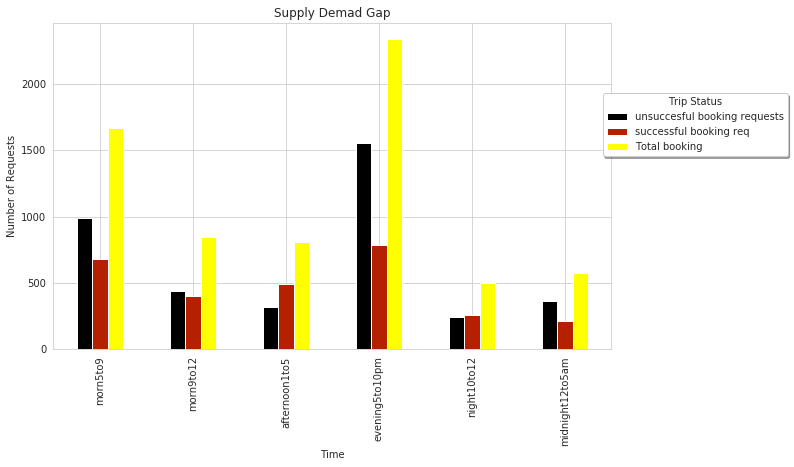

In [21]:
supply_dem_gap[["failed requests","Trip Completed","total_requests"]].plot(kind='bar',figsize=[10,6], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Supply Demad Gap")
plt.legend(title='Trip Status', labels=['unsuccesful booking requests', 'successful booking req', 'Total booking'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



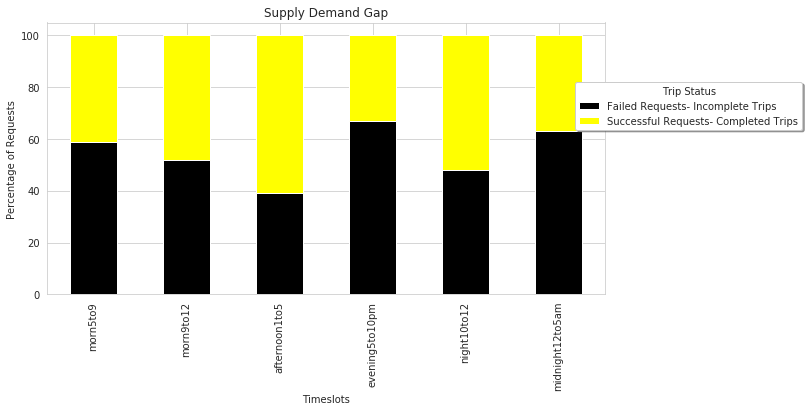

In [22]:
supply_dem_gap[["%Failed_req","%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Timeslots")
plt.ylabel("Percentage of Requests")
plt.title("Supply Demand Gap")
plt.legend(title='Trip Status', labels=['Failed Requests- Incomplete Trips', 'Successful Requests- Completed Trips'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


****Trip Status Count - Time Slots - Airport to City


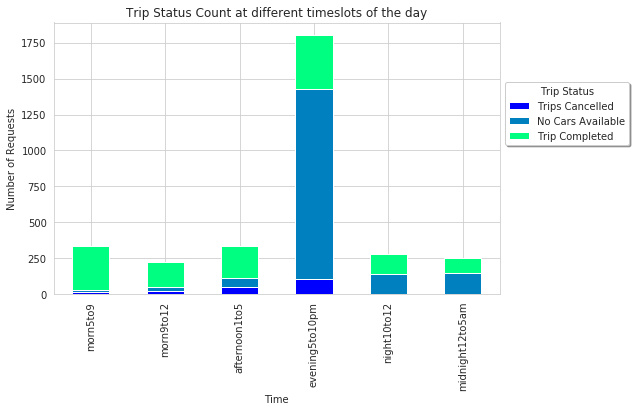

In [23]:

morn5to9=pd.DataFrame(airportsupdemgap.loc[5:8].sum())
morn9to12=pd.DataFrame(airportsupdemgap.loc[9:11].sum())
afternoon1to5=pd.DataFrame(airportsupdemgap.loc[12:16].sum())
evening5to10pm=pd.DataFrame(airportsupdemgap.loc[17:21].sum())
night10to12=pd.DataFrame(airportsupdemgap.loc[22:23].sum())
midnight12to5am=pd.DataFrame(airportsupdemgap.loc[0:4].sum())

slots=pd.concat([morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am],axis=1)

slots.columns=["morn5to9","morn9to12","afternoon1to5","evening5to10pm","night10to12","midnight12to5am"]

slots.reset_index(inplace=True)
slots.drop("level_0",axis=1,inplace=True)

slots.set_index("Status",inplace=True)
gap=slots.T
gap.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Trip Status Count at different timeslots of the day")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



  


In [24]:
total=slots.sum()
cancel=round((slots.loc["Cancelled"]/total)*100)
nocars=round((slots.loc["No Cars Available"]/total)*100)
tripcomp=round((slots.loc["Trip Completed"]/total)*100)
fail=slots.iloc[:2].sum()
failperc=round((fail/total)*100)
supply_dem_gap=pd.concat([gap,pd.DataFrame(columns =["%cancelled", "%NoCarsAvail", "%TripCompleted","%Failed_req",
           "failed requests","total_requests"])])
supply_dem_gap["%cancelled"]=cancel
supply_dem_gap["%NoCarsAvail"]=nocars
supply_dem_gap["%TripCompleted"]=tripcomp
supply_dem_gap["%Failed_req"]=failperc
supply_dem_gap["failed requests"]=fail
supply_dem_gap["total_requests"]=total

supply_dem_gap


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,%Failed_req,%NoCarsAvail,%TripCompleted,%cancelled,Cancelled,No Cars Available,Trip Completed,failed requests,total_requests
morn5to9,9.0,4.0,91.0,4.0,15.0,14.0,308.0,29.0,337.0
morn9to12,23.0,13.0,77.0,10.0,22.0,30.0,176.0,52.0,228.0
afternoon1to5,34.0,19.0,66.0,15.0,50.0,64.0,225.0,114.0,339.0
evening5to10pm,79.0,73.0,21.0,6.0,106.0,1321.0,373.0,1427.0,1800.0
night10to12,49.0,48.0,51.0,1.0,3.0,136.0,142.0,139.0,281.0
midnight12to5am,59.0,58.0,41.0,1.0,2.0,148.0,103.0,150.0,253.0


****Trip Status Percentage - Early Morning to Late night Slots


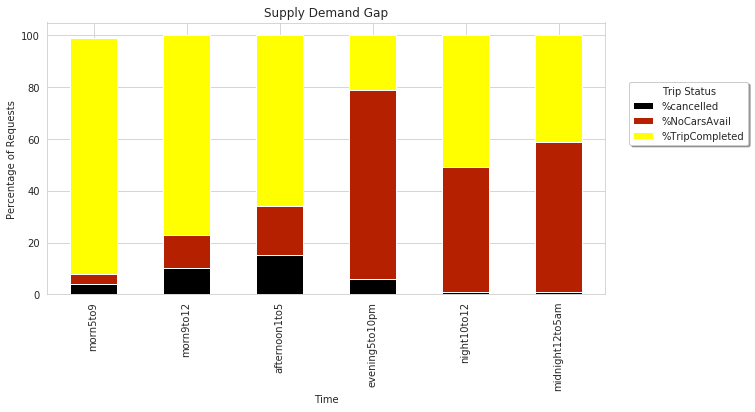

In [25]:
supply_dem_gap[["%cancelled", "%NoCarsAvail", "%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Percentage of Requests")
plt.title("Supply Demand Gap")
plt.legend(title='Trip Status', labels=["%cancelled", "%NoCarsAvail", "%TripCompleted"],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



****Failed and Successful Trip Percentage - Early Morning to Late night Slots
Failed and Successful Count


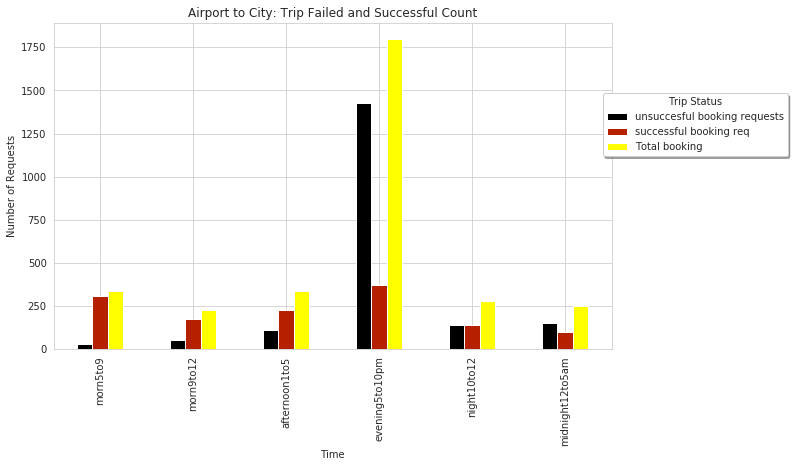

In [26]:
supply_dem_gap[["failed requests","Trip Completed","total_requests"]].plot(kind='bar',figsize=[10,6], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Airport to City: Trip Failed and Successful Count")
plt.legend(title='Trip Status', labels=['unsuccesful booking requests', 'successful booking req', 'Total booking'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



****Observation: City to Airport
Average Supply-Demand gap of 57% (43% of total trips requests are completed across all the timeslots).
- 57% incomplete requests: 27% is due to Unavailability of cars and 30% due to cancellation by drivers.
Highest demand during 0500hrs-1000hrs - 73% Non Availability of Cars and 6% Cancelled requests


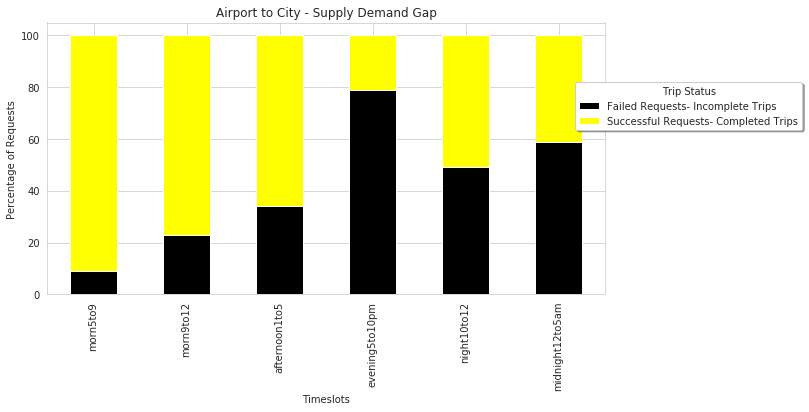

In [27]:
supply_dem_gap[["%Failed_req","%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Timeslots")
plt.ylabel("Percentage of Requests")
plt.title("Airport to City - Supply Demand Gap")
plt.legend(title='Trip Status', labels=['Failed Requests- Incomplete Trips', 'Successful Requests- Completed Trips'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



In [28]:

Trip Status Count - Time Slots - City to Airport
morn5to9=pd.DataFrame(citysupdemgap.loc[5:8].sum())
morn9to12=pd.DataFrame(citysupdemgap.loc[9:11].sum())
afternoon1to5=pd.DataFrame(citysupdemgap.loc[12:16].sum())
evening5to10pm=pd.DataFrame(citysupdemgap.loc[17:21].sum())
night10to12=pd.DataFrame(citysupdemgap.loc[22:23].sum())
midnight12to5am=pd.DataFrame(citysupdemgap.loc[0:4].sum())

slots=pd.concat([morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am],axis=1)

slots.columns=["morn5to9","morn9to12","afternoon1to5","evening5to10pm","night10to12","midnight12to5am"]
slots.reset_index(inplace=True)
slots.drop("level_0",axis=1,inplace=True)

slots.set_index("Status",inplace=True)
gap=slots.T
gap.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Trip Status Count: City to Airport")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



SyntaxError: invalid syntax (<ipython-input-28-11ef0bf3890e>, line 1)

In [ ]:
total=slots.sum()
cancel=round((slots.loc["Cancelled"]/total)*100)
nocars=round((slots.loc["No Cars Available"]/total)*100)
tripcomp=round((slots.loc["Trip Completed"]/total)*100)
fail=slots.iloc[:2].sum()
failperc=round((fail/total)*100)
supply_dem_gap=pd.concat([gap,pd.DataFrame(columns =["%cancelled", "%NoCarsAvail", "%TripCompleted","%Failed_req",
           "failed requests","total_requests"])])
supply_dem_gap["%cancelled"]=cancel
supply_dem_gap["%NoCarsAvail"]=nocars
supply_dem_gap["%TripCompleted"]=tripcomp
supply_dem_gap["%Failed_req"]=failperc
supply_dem_gap["failed requests"]=fail
supply_dem_gap["total_requests"]=total

supply_dem_gap

  



****City to Airport - Trip Status Percentage - Early Morning to Late night Slots
City to Airport

In [ ]:

supply_dem_gap[["%cancelled", "%NoCarsAvail", "%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Percentage of Requests")
plt.title("Supply Demand Gap: City to Airport")
plt.legend(title='Trip Status', labels=["%cancelled", "%NoCarsAvail", "%TripCompleted"],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


****City to Airport- Failed and Successful Trip Percentage - Early Morning to Late night Slots
rport


In [ ]:

supply_dem_gap[["failed requests","Trip Completed","total_requests"]].plot(kind='bar',figsize=[10,6], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("City to Airport: Trip Failed and Successful Count")
plt.legend(title='Trip Status', labels=['unsuccesful booking requests', 'successful booking req', 'Total booking'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)



In [ ]:
supply_dem_gap[["%Failed_req","%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Timeslots")
plt.ylabel("Percentage of Requests")
plt.title("City to Airport- Supply Demand Gap")
plt.legend(title='Trip Status', labels=['Failed Requests- Incomplete Trips', 'Successful Requests- Completed Trips'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


****1. Supply demand gap of 59% on average over whole day - "Airport to City".
1.1 Most common cause of supply demand gap - "Non availability of cars".
1.2 Most Problematic timeslots:
      - evening5to10, 79% unsuccessful trips being 73% due to non availability of cars
2. Supply demand gap of 57% on an avaerage over whole day - "City to Airport".
2.1 Cause -30% due to cancellation by drivers and 27% due to "Non availability of cars".
2.2 Most Problematic timeslots:
      - morning5to9, 72% unsuccessful trips being 49% due to cancellation and 23% due to non avaialability of cars
      - midnight12to5, 66% failed trips being 46% due to non availability of cars.


****Conclusions after EDA:
1. Considering timeslots with highest supply demand gaps from airport to city i.e. 5 to 10 pm only 70-80 requests each side are completed from City-Airport and Airport-City, it means the reason "no cars available" is not completely due to half of those cars are in transit but it indicates that all 300 cars are not at service even when there is such a high demand of total approx. 500 requests from both points.
2. Morning 0500-0900hrs, the high supply demand gap from city to airport is not due to cars not being available at service but even when they are available, the drivers are cancelling the requests which again is not because they all are serving other requests but there is some other unknown reason which is evident from the fact that at 5 am approx 350 requests are from city and only 100 are completed, and in the same duration 85 requests are completed from airport.
3. Total 300 cars
300 unique driver ids i.e. 300 cars in total and the highest requests at one timeslot from all pickup ponts is as high as 500 recorded at 1800hrs.


Possible recommendations:
1. Provision of more cars because demand goes as high as 500 at late evenings.
2. Addressing the issue of cars not being at service to customers at all, evident from the fact that only 120-170 requests are completed even when there are total 300 cars existing for service.
3. Early morning the City requests being cancelled in large numbers by drivers needs to be addressed as well.
Need to find all possible causes of cars not being at service and never is there a time when there is no supply demand gap even when number of cars are much higher as compared to the requests. This issue can be resolved by driver's feedback for the cause of cancellations and being unavailable for work in high demand hours.